# Создание и нормализация базы данных.

## Преобразование xlsx в таблицы базы данных.
![Transaction database](tansaction.svg)

## Нормализация

Изначальные таблицы(transaction, customer) соответсвовали 1 НФ, потому что значения атомарны.

2 НФ нарушена в таблице transaction, потому некоторые поля не зависят от transaction_id(brand, product_line, тд)
2 НФ нарушена в таблице customer по той же причине(contry, property_valuation, state, job_title, job_indeustry_category не зависят от customer_id)

И эти таблицы не соответсвуют 3 НФ, потому что присутсвуют транзитивные зависимости. Новая БД выше соотвествует 1, 2, 3 НФ.

## Импортируем данные из xlsx в базу данных

In [21]:
import secretstorage as sec

def get_database_password(connection: sec.DBusConnection) -> str:
    collection = sec.get_default_collection(connection)
    # Поиск секрета по атрибуту "service"
    for item in collection.search_items({'service': 'ipynb'}):
        if item.is_locked():
            item.unlock()
        return item.get_secret().decode("cp1251").strip()

    return ""


In [22]:
connection = sec.dbus_init()

In [23]:
import pandas as pd
import psycopg2 as pg

transaction = pd.read_excel("data/customer_and_transaction.xlsx")

# Connect to database
db_conn = pg.connect(dbname="study", host="localhost", user="postgres", password=get_database_password(connection))
cursor = db_conn.cursor()

In [24]:
# Create Products
try:
    cursor.execute("""CREATE TABLE Products (
        row_id serial PRIMARY KEY,
        index integer,
        brand varchar,
        product_line varchar,
        product_class varchar,
        product_size varchar,
        list_price float,
        standard_cost float
    )
    """)

    # Init Product
    products_data = transaction[["product_id", "brand", "product_line", "product_class", "product_size", "list_price", "standard_cost"]].drop_duplicates().values
    for product_id, brand, product_line, product_class, product_size, list_price, standard_cost in products_data:
        cursor.execute("""INSERT INTO Products (index, brand, product_line, product_class, product_size, list_price, standard_cost)
                    VALUES(%s, %s, %s, %s, %s, %s, %s)               
        """, (product_id, brand, product_line, product_class, product_size, list_price, standard_cost))
except Exception as e:
    print(f"Ошибка создание и заполнение таблицы: {e}")
    db_conn.rollback()
else:
    db_conn.commit()

In [25]:
customer = pd.read_excel("data/customer_and_transaction.xlsx", 1)

In [26]:
# Create Address
try:
    cursor.execute("""CREATE TABLE Address (
        row_id serial PRIMARY KEY,
        address varchar NOT NULL,
        postcode integer NOT NULL,
        state varchar NOT NULL,
        country varchar NOT NULL,
        property_valuation integer NOT NULL
    )
    """)

    # Init Address
    address_data = customer[["address", "postcode", "state", "country", "property_valuation"]].drop_duplicates().values
    for address, postcode, state, country, property_valuation in address_data:
        cursor.execute("""INSERT INTO Address (address, postcode, state, country, property_valuation)
                    VALUES(%s, %s, %s, %s, %s)               
        """, (address, postcode, state, country, property_valuation))
except Exception as e:
    print(f"Ошибка создание и заполнение таблицы: {e}")
    db_conn.rollback()
else:
    db_conn.commit()

In [27]:
# Create Job
try:
    cursor.execute("""CREATE TABLE Job (
        row_id serial PRIMARY KEY,
        job_title varchar,
        job_industry_category varchar NOT NULL
    )
    """)

    # Init Job
    jobs_data = customer[["job_title", "job_industry_category"]].drop_duplicates().values
    for job_title, job_industry_category in jobs_data:
        cursor.execute("""INSERT INTO Job (job_title, job_industry_category)
                    VALUES(%s, %s)               
        """, (job_title, job_industry_category))
except Exception as e:
    print(f"Ошибка создание и заполнение таблицы: {e}")
    db_conn.rollback()
else:
    db_conn.commit()

In [28]:
# Create Customer
try:
    cursor.execute("""CREATE TABLE Customer (
        id integer PRIMARY KEY,
        first_name varchar NOT NULL,
        last_name varchar,
        gender varchar NOT NULL,
        dob date,
        wealth_segment varchar NOT NULL,
        deceased_indicator bool NOT NULL,
        own_car bool NOT NULL,
        job_id integer NOT NULL,
        address_id integer NOT NULL
    );
    """)
    
    cursor.execute("""
        ALTER TABLE Customer ADD FOREIGN KEY("job_id") REFERENCES Job("row_id");               
    """)
    
    cursor.execute("""
        ALTER TABLE Customer ADD FOREIGN KEY("address_id") REFERENCES Address("row_id");               
    """)

    # Init Customer
    for id, first_name, last_name, gender, DOB, job_title, job_industry_category, wealth_segment, deceased_indicate, own_car, address, postcode, state, country, property_valuation in customer.values:
        date_value = pd.to_datetime(DOB, errors="coerce")
        cursor.execute("""
            SELECT row_id FROM Job WHERE job_title = %s AND job_industry_category = %s
        """, (job_title if pd.notna(job_title) else "NaN", job_industry_category if pd.notna(job_industry_category) else "NaN"))
        res = cursor.fetchone()
        if (not res):
            raise RuntimeError(f"Failed to get job_id by {job_title}, {job_industry_category}")
        job_id = res[0]

        cursor.execute("""
            SELECT row_id FROM Address WHERE address = %s AND postcode = %s AND state = %s AND country = %s AND property_valuation = %s
        """, (address, postcode, state, country, property_valuation))
        res = cursor.fetchone()
        if (not res):
            raise RuntimeError(f"Failed to get address_id by {address}, {postcode}, {state}, {country}, {property_valuation}")
        address_id = res[0]
        cursor.execute(
            """INSERT INTO Customer VALUES(%s, %s, %s, %s, %s, %s, %s, %s, %s, %s)""",(
                id, first_name, last_name, gender, date_value if pd.notna(date_value) else None, wealth_segment,
                deceased_indicate == 'Y', own_car == "Yes", job_id,  address_id))
except Exception as e:
    print(f"Ошибка создание и заполнение таблицы: {e}")
    db_conn.rollback()
else:
    db_conn.commit()



In [29]:
# Create Transaction
try:
    cursor.execute("""CREATE TABLE Transaction (
        id integer PRIMARY KEY,
        transaction_date date NOT NULL,
        online_order bool,
        order_status varchar NOT NULL,
        customer_id integer NOT NULL,
        product_id integer NOT NULL
    );
    """)
    
    cursor.execute("""
        ALTER TABLE Transaction ADD FOREIGN KEY("customer_id") REFERENCES Customer("id");               
    """)
    
    cursor.execute("""
        ALTER TABLE Transaction ADD FOREIGN KEY("product_id") REFERENCES Products("row_id");               
    """)

    # Init Transaction
    for transaction_id, product_id, customer_id, transaction_date, online_order, order_status, brand, product_line, product_class, product_size, list_price, standard_cost in transaction.values:
        cursor.execute("""
            SELECT * FROM Customer WHERE id = %s""", (customer_id,))
        if (not cursor.fetchone()):
            print(f"User by id {customer_id} NOT FOUND, SKIP")
            continue
        
        date_value = pd.to_datetime(transaction_date, errors="coerce")
        cursor.execute("""
            SELECT row_id FROM Products
            WHERE index = %s AND brand = %s AND product_line = %s AND product_class = %s AND product_size = %s AND list_price = %s AND standard_cost = %s
        """, (product_id,
            brand if pd.notna(brand) else "NaN",
            product_line if pd.notna(product_line) else "NaN",
            product_class if pd.notna(product_class) else "NaN",
            product_size if pd.notna(product_size) else "NaN",
            list_price if pd.notna(list_price) else "NaN",
            standard_cost if pd.notna(standard_cost) else "NaN"))
        res = cursor.fetchone()
        if (not res):
            raise RuntimeError(f"Failed to get product_id by {product_id}, {brand}, {product_line}, {product_class}, {product_size}, {list_price}, {standard_cost}")
        product_row_id = res[0]
        cursor.execute(
            """INSERT INTO Transaction VALUES(%s, %s, %s, %s, %s, %s)""",(
                transaction_id, date_value if pd.notna(date_value) else None, online_order if pd.notna(online_order) else None, order_status, customer_id, product_row_id))
except Exception as e:
    print(f"Ошибка создание и заполнение таблицы: {e}")
    db_conn.rollback()
else:
    db_conn.commit()



User by id 5034 NOT FOUND, SKIP
User by id 5034 NOT FOUND, SKIP
User by id 5034 NOT FOUND, SKIP


## Данные DBeaver
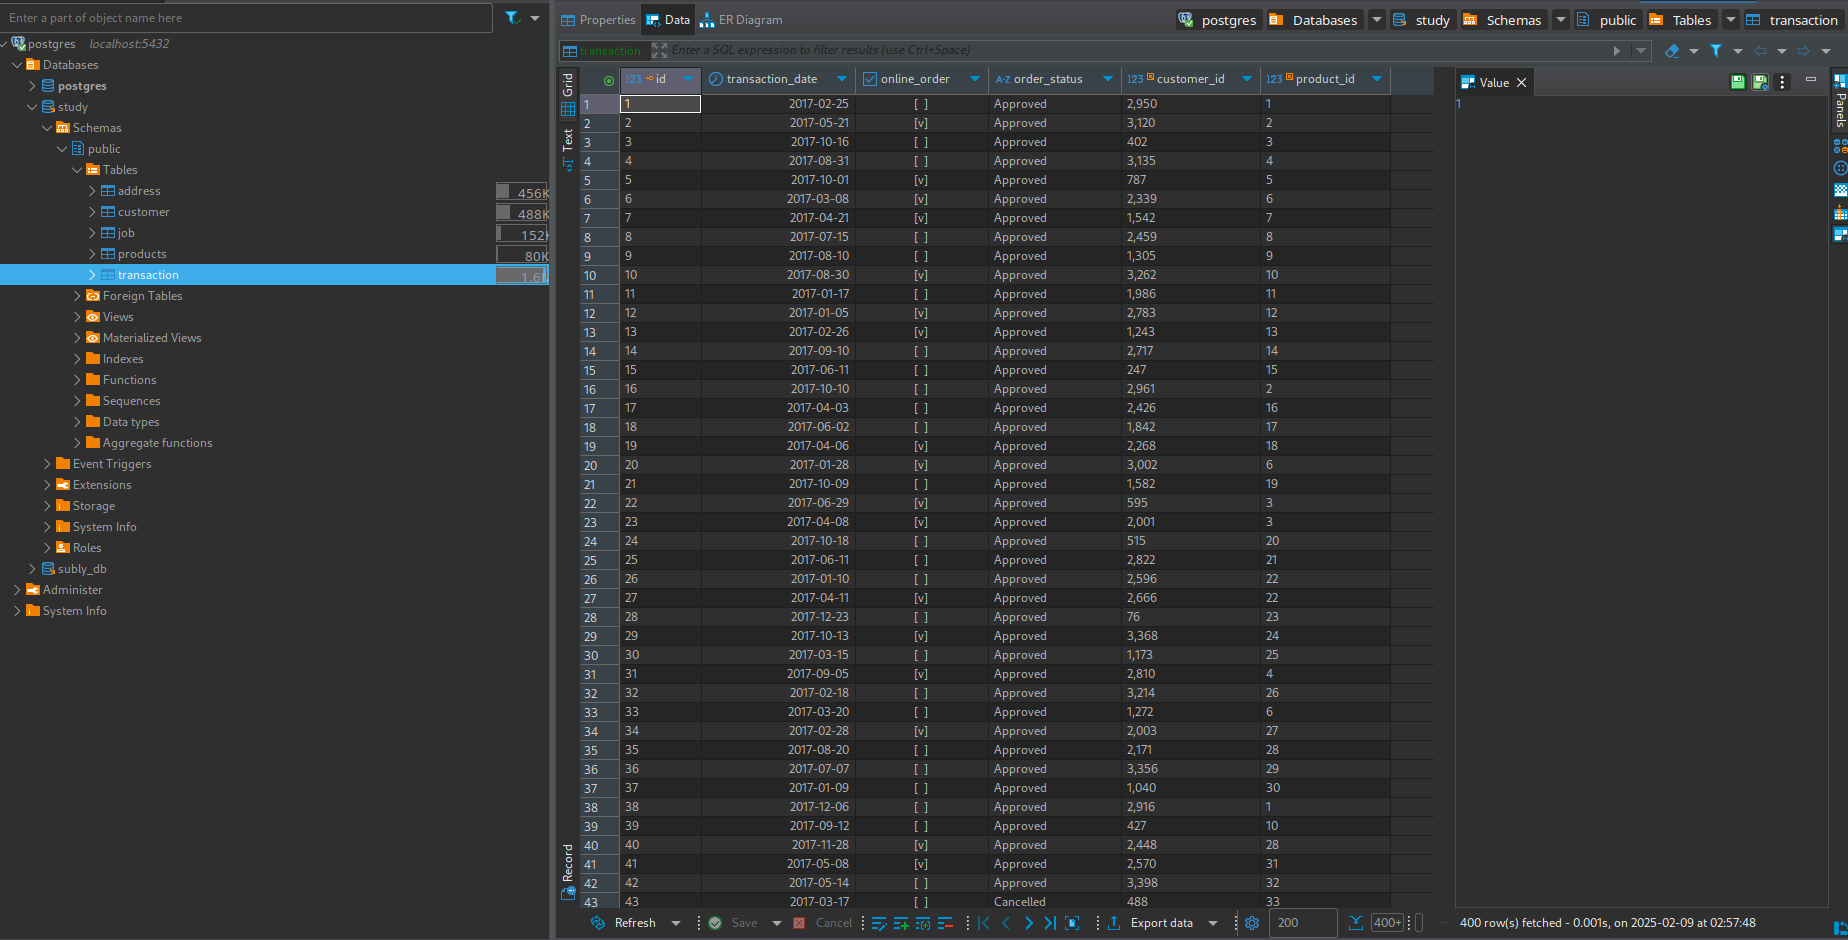

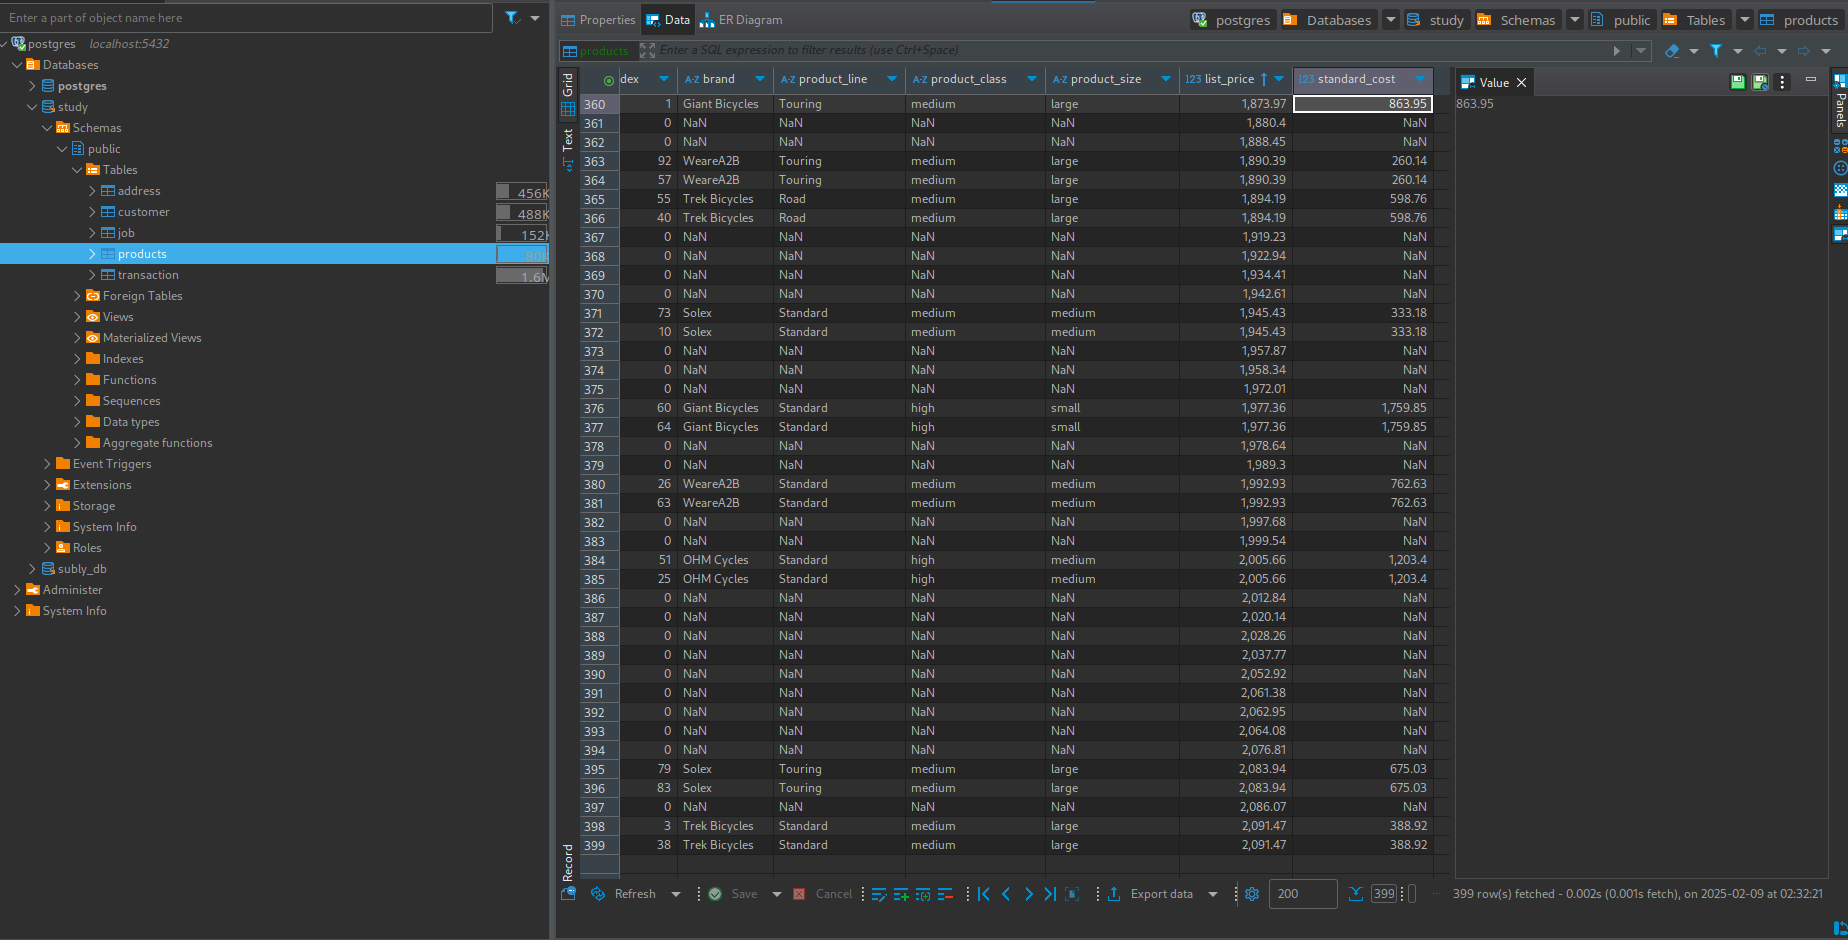

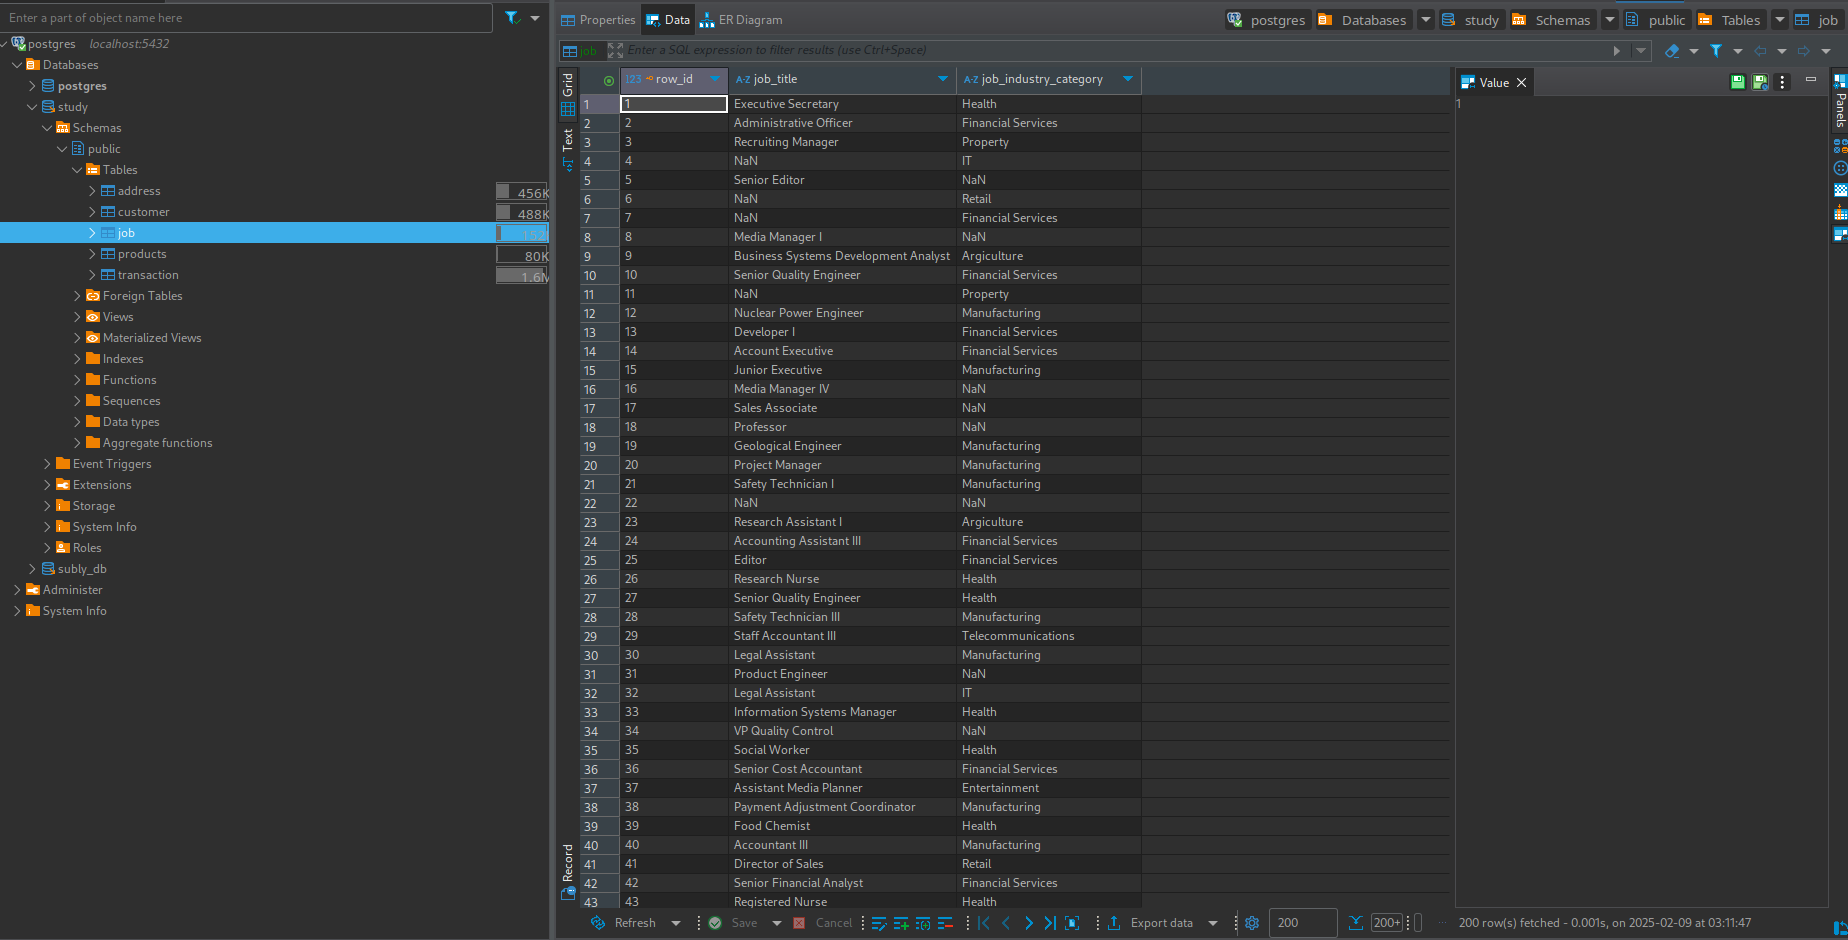

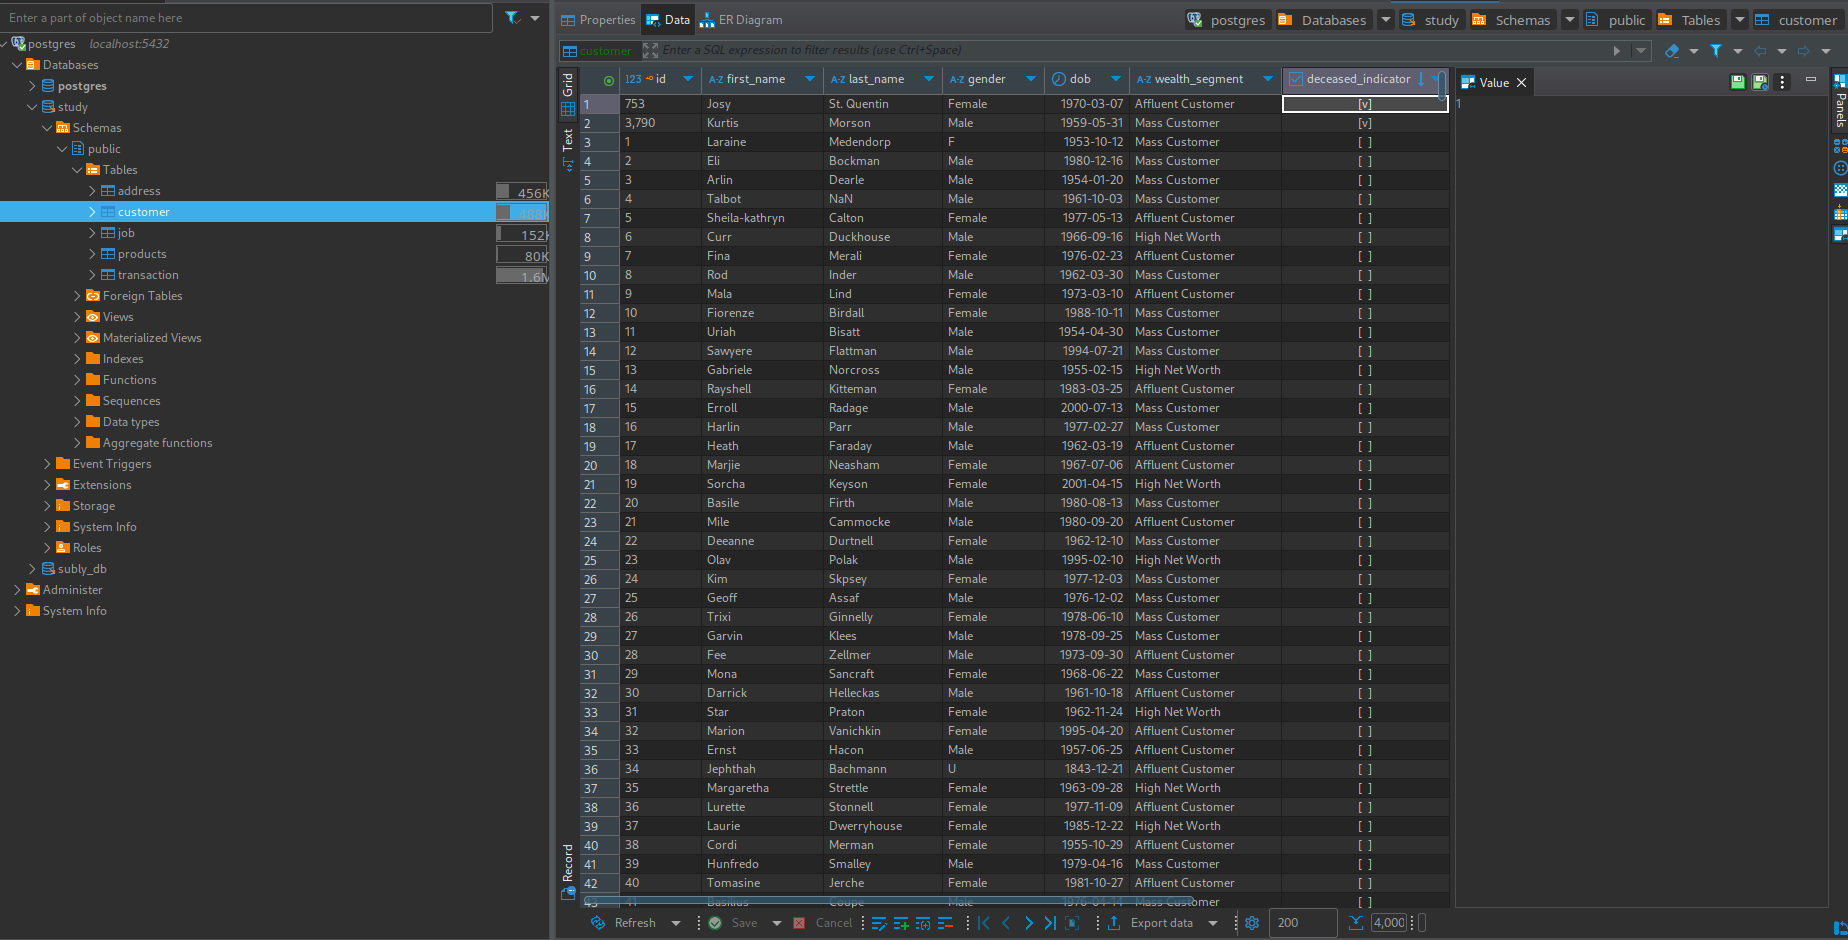

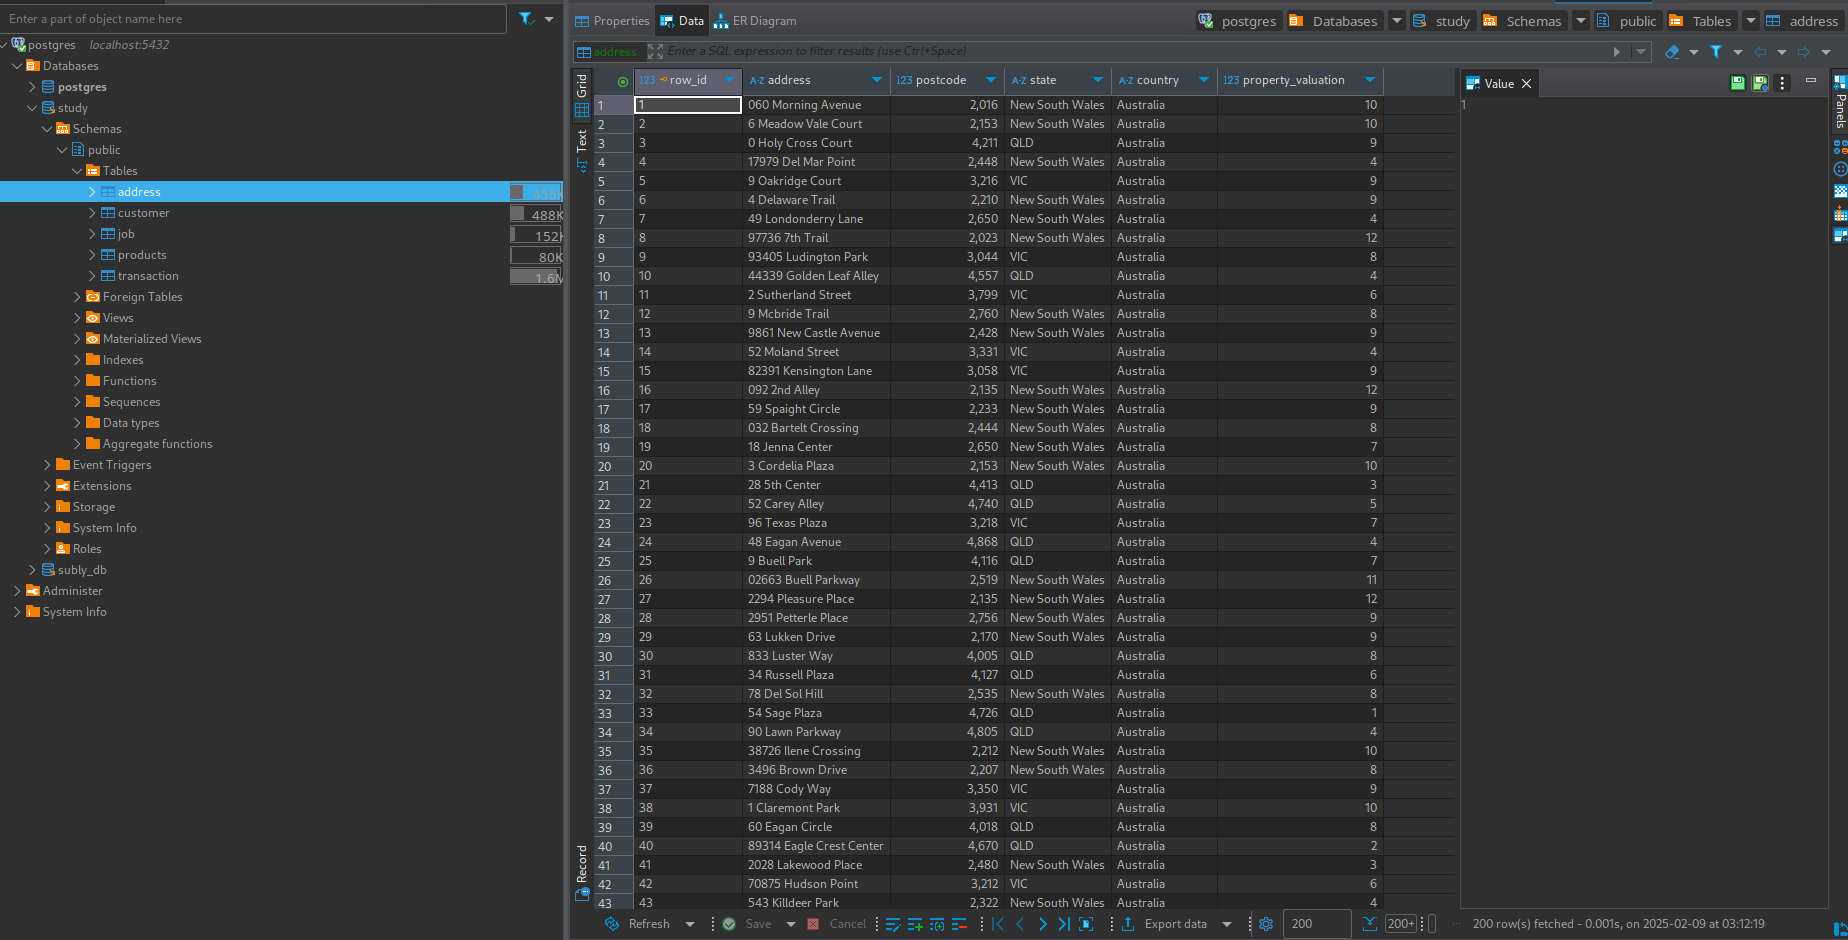

## Результат
- Таблица переведа в **psql database**.
- Таблицы приведены к **3НФ**.

В качестве улучшение, можно вынести повторяющиеся поля(страна, штат, статус заказа, ...) в отдельную таблицу.
Так же можно разделить адрес на компоненты, если есть такая необходимость. В контексте этой задачи - адрес атомарный.